In [ ]:
#@title Import & pip
%%capture
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from google.colab import drive
drive.mount('./MyDrive')
!pip install -U --no-cache-dir pymoo
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.ga  import GA
from pymoo.core.problem import Problem
from pymoo.util.termination.f_tol import MultiObjectiveSpaceToleranceTermination
from pymoo.util.termination.x_tol import DesignSpaceToleranceTermination
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.util.display import Display
from pymoo.operators.mixed_variable_operator import MixedVariableSampling, MixedVariableMutation, MixedVariableCrossover
from pymoo.core.problem import ElementwiseProblem
!pip install pykrige
!pip install tqdm
from tqdm import tqdm, trange
!pip install pyDOE
import pyDOE
import time
import scipy.stats
import copy
import pandas as pd
# ! pip install import_ipynb
# import import_ipynb
# import Regression HK_class.ipynb

In [ ]:
class HK:

  ###################################
  def __init__(self, x, y, args=None, HKtype = "r"):
    self.t_start = time.time()
    self.x, self.y = x, y
    self.q = args
    self.pop, self.gen = np.array([self.q["npop"], self.q["npop"]]), np.array([self.q["nge"], self.q["nge"]])
    self.total_level = len(x)
    self.current_level = 0
    self.HKtype = HKtype # Regression: "r" & Interpolation: "i"
    if self.HKtype == "i":
      self.total_opt_theta, self.total_R, self.total_invR, self.total_F, self.total_beta, self.total_sigmaSQ, self.total_MLE = [], [], [], [], [], [], []
    elif self.HKtype == "r":
      self.total_opt_theta, self.total_opt_nugget, self.total_opt_order, self.total_R, self.total_invR, self.total_F, self.total_beta, self.total_sigmaSQ, self.total_MLE = [], [], [], [], [], [], [], [], []
    else:
      print("Invalid HK type")
     
  ###################################
  def regression(self, ann=False, to_level = None):
    if to_level == None: # to_level 입력안되면 모든 fidelity 학습
      to_level = self.total_level-1
    
    while self.current_level < to_level + 1 :
      if ann == True:
        print("#########  Level %d starts  #########" % (self.current_level))
      t_temp = time.time()
      x, y = self.x[self.current_level], self.y[self.current_level]

      self.opt_bef_action()
      self.GA_results = self.GA_krig(self.current_level)
      self.opt_X = self.GA_results[0]
      self.opt_aft_action(x,y,self.opt_X)

      result = []
      result.append(self.total_F)
      result.append(self.opt_X)

      announce = "   Final generation = %s" % (self.GA_results[2])
      announce += "\n   Optimal theta = %s" % (self.total_opt_theta[self.current_level])
      if self.HKtype == "r":
        announce += "\n   Optimal nugget = %E" % (self.total_opt_nugget[self.current_level])
      announce += "\n   Optimal likelihood = %f" % (self.total_MLE[self.current_level])
      announce += "\n   Optimal R's condition number = %f" % (np.linalg.cond(self.total_R[self.current_level]))
      announce += "\n   Level %d finishes with time %f[s]" % (self.current_level, time.time()-t_temp)

      if ann == True:
        print(announce)

      self.current_level += 1

    if ann == True:
      print("#########  HK total training time = %f[s]  #########\n" % (time.time()-self.t_start))
    
    return result, self.total_opt_theta #$%^&
  
  ###################################
  def opt_bef_action(self): #x,y,current_level,*args): 
    
    self.N_pts = self.x[self.current_level].shape[0]

    if self.current_level == 0 :
      F = np.ones(self.N_pts) 
    else :# if current_level != 0 --> F = estimate으로넣기
      F = self.prediction(self.x[self.current_level], self.current_level-1)[0]
    
    self.total_F.append(F)

  ###################################
  def prediction(self,x_test,test_level, surro_dir = None): #$%^&
    # HF들의 y와 MSE 계산에는 r_vector와 y_pred의 계산만 새로 필요. 나머지는 새로 계산할 필요 없음

    # f = open(os.path.join(surro_dir, f"F_coeff{nydim}.dat"), "r")
    # total_F = []
    # data = f.readlines()
    # for i in range(len(data)):
    #     total_F.append(data[i].split())
    # f.close()
    # for i in range(len(total_F)):
    #   for j in range(len(total_F[i])):
    #     total_F[i][j] = float(total_F[i][j])
    #   total_F[i] = np.array(total_F[i])
    # self.total_F = np.array(total_F)
    #
    # f = open(os.path.join(surro_dir, f"opt_coeff{nydim}.dat"), "r")
    # opt_X = f.readline().split()
    # f.close()
    # for i in range(len(opt_X)):
    #   opt_X[i] = float(opt_X[i])
    #
    # x, y = self.x[test_level], self.y[test_level]        #####  test level이 맞나?
    # self.opt_aft_action(x, y, opt_X)                     #####  앞에서 끌어옴
    if surro_dir != None: #$%^&
      self.total_opt_theta = surro_dir #$%^&
    
    N_pts_test = self.x[test_level].shape[0]
    R = self.total_R[test_level]
    invR = self.total_invR[test_level]
    
    if self.HKtype == "i":
      temp_X = self.total_opt_theta[test_level]
    elif self.HKtype == "r":
      temp_X = self.total_opt_theta[test_level]
      temp_X = np.append(temp_X,self.total_opt_nugget[test_level])
          
    r_vector = self.cal_r_vector(x_test,temp_X,test_level)
    F = self.total_F[test_level]                                              #### self.total_F >>> total_F
    beta = self.total_beta[test_level]
    sigmaSQ = self.total_sigmaSQ[test_level]
    

    if self.HKtype == "i":
      if test_level == 0 :

        y_pred = beta + r_vector.transpose() @ invR @ ( self.y[test_level] - F * beta)
        MSE = []
        
        for i in range(x_test.shape[0]) :
          MSE.append(sigmaSQ * (1 - r_vector.transpose()[i]@ invR @ r_vector[:,i] + (1 - F.transpose() @ invR @ r_vector[:,i]) ** 2 / (F.transpose() @ invR @ F)))
                    
      else :
        y_lf = self.prediction(x_test, test_level-1)[0]
        y_pred = beta * y_lf + r_vector.transpose() @ invR @ ( self.y[test_level] - F * beta)
        
        temp_1 = 1 / (F.transpose() @ invR @ F)
        MSE = []
        
        for i in range(x_test.shape[0]) :
          
          temp_2 = r_vector.transpose()[i]@ invR @ r_vector[:,i]
          temp_3 = r_vector.transpose()[i]@ invR @ F
          
          MSE.append((sigmaSQ * (1 - temp_2 + ( temp_3 - y_lf[i] ) * (temp_1) * (temp_3 - y_lf[i]))))
          
    if self.HKtype == "r":
      # nugget 그냥 빼버리면 inv 계산에서 또 수치에러 발생. 이를 완화위해 trick으로 10**-9 fixed nugget 사용
      regression_invR = np.linalg.inv(R - self.total_opt_nugget[test_level] * np.identity(N_pts_test) + 10**-9 * np.identity(N_pts_test))
      regression_sigmaSQ = self.cal_regression_sigmaSQ(N_pts_test, self.y[test_level], F, beta, R, invR, self.total_opt_nugget[test_level])

      if test_level == 0 :
        
        y_pred = beta + r_vector.transpose() @ invR @ ( self.y[test_level] - F * beta)
        MSE = []
        
        for i in range(x_test.shape[0]) :
          
          MSE.append(regression_sigmaSQ * (1  - r_vector.transpose()[i]@ regression_invR @ r_vector[:,i] + (1 - F.transpose() @ regression_invR @ r_vector[:,i]) ** 2 / (F.transpose() @ regression_invR @ F)))
          
          
      else :
        
        y_lf = self.prediction(x_test, test_level-1)[0]
        y_pred = beta * y_lf + r_vector.transpose() @ invR @ ( self.y[test_level] - F * beta)
        
        temp_1 = 1 / (F.transpose() @ regression_invR @ F)
        MSE = []
        
        for i in range(x_test.shape[0]) :
          
          temp_2 = r_vector.transpose()[i]@ regression_invR @ r_vector[:,i]
          temp_3 = r_vector.transpose()[i]@ regression_invR @ F
          
          MSE.append((regression_sigmaSQ * ( 1  - temp_2 + ( temp_3 - y_lf[i] ) * (temp_1) * (temp_3 - y_lf[i]))))
          
    MSE = np.array(MSE)
    MSE[MSE < 0] = 0
    return y_pred, np.sqrt(MSE)

  ###################################
  def opt_aft_action(self,x,y,opt_X):
    
    N_pts = self.x[self.current_level].shape[0]
    R=self.cal_R(x,y,opt_X)
    invR = np.linalg.inv(R)

    F = self.total_F[self.current_level]

    transF = F.transpose() 
    beta = self.cal_beta(self.y[self.current_level], F, invR, transF)
    sigmaSQ = self.cal_sigmaSQ(N_pts, self.y[self.current_level], F, beta, invR)
    MLE = self.cal_MLE(N_pts, sigmaSQ, R)

    if self.HKtype == "i":
      opt_theta = opt_X
          
    if self.HKtype == "r":
      opt_theta = opt_X[:-1]
      opt_nugget = opt_X[-1]
      self.total_opt_nugget.append(opt_nugget)
    
    self.total_opt_theta.append(opt_theta)
    self.total_R.append(R)
    self.total_invR.append(invR)
    self.total_beta.append(beta)
    self.total_sigmaSQ.append(sigmaSQ)
    self.total_MLE.append(MLE)
      
  ###################################
  def cal_r(self, x1, x2, X): 
    
      if self.HKtype == "i":
        theta = X
        
      elif self.HKtype == "r":
        theta = X[:-1]
      
      eps = theta*np.abs(x1-x2)
      for enu,temp in enumerate(eps) :
        if temp <= 0.2 :
          eps[enu] = 1 - 15 * temp**2 + 30 * temp**3
        elif 0.2 < temp < 1 :
          eps[enu] = 1.25 * (1-temp)**3
        else :
          eps[enu] = 0
      return np.prod(eps)
        
  ###################################      
  def cal_r_vector (self, x_test, X, test_level) : # x_test shape : (test 데이터 개수, N_dimension)
      
      r_vector = np.zeros((self.x[test_level].shape[0],x_test.shape[0])) # r_vector shape : ( 해당 레벨에서 실제 샘플 데이터 개수,test 데이터 개수) --> 이렇게해야 추후 식들에서 r의 차원이 맞음

      for enu1, temp1 in enumerate(x_test) :

        r_vector[:,enu1] = np.array([self.cal_r(temp1,temp2,X) for temp2 in self.x[test_level]])
      
      return r_vector

  ###################################  
  def cal_R(self,x,y,X): # x : (N_pts,N_dv)의 shape을 가지는 dv값 array, shape : 1차원으로 N_dv개수만큼 원소있음
      
      N_pts = x.shape[0]
      R = np.zeros((N_pts,N_pts)) 

      for i in range(N_pts) :
          for j in range(i + 1, N_pts):
            R[i, j] = self.cal_r(x[i], x[j], X)
      
      if self.HKtype == "i":
        nugget = 10**-12
      elif self.HKtype == "r":
        nugget = X[-1]
      
      return R + R.transpose() + (1 + nugget) * np.identity(N_pts)

  ###################################  
  def cal_beta(self, Y, F, invR, transF) :
      temp_beta = 1 / ((F @ invR @ transF)) 

      return temp_beta * transF @ invR @ Y

  ###################################  
  def cal_sigmaSQ(self, N_pts, Y, F, beta, invR):
        
      return 1 / N_pts * (Y - F * beta).transpose() @ invR @ (Y - F * beta)

  ###################################  
  def cal_regression_sigmaSQ(self, N_pts, Y, F, beta, R, invR, nugget):
          
      return 1 / N_pts * (Y - F * beta).transpose() @ invR @ ( R - nugget * np.identity(N_pts)) @ invR @ (Y - F * beta)

  ###################################  
  def cal_MLE(self, N_pts, sigmaSQ,R):

      det_R = np.linalg.det(R)

      if det_R == 0 :
        return np.float64(-9999.) # det_R = 0 나오면 MLE가 inf가 나와서 해당 theta가 최적해로 뽑혀버림. 이를 방지위해 
      else : 
        MLE = - (N_pts/2) * np.log(sigmaSQ) - 1 / 2 * np.log(np.linalg.det(R)) # MEDOC version Log-likelihood
        return MLE

  ###################################  
  def plot_var(self,x_test,level,function=None):
    plt.style.use('seaborn-ticks')
    
    total_level = len(self.x)
    y_HK= self.prediction(x_test, level)
    col = ['b','r','g']
    for i in range(level+1) :
      # plt.scatter(x[i],y[i],marker = 'o',color='red')
      label_ = "Fidelity-level %d data" % i
      plt.scatter(self.x[i],self.y[i],label=label_,color=col[i])
    if function:
      plt.plot(x_test,function(x_test),'r-',label="True function")
    if self.HKtype == "r" and level > 0:
      plt.plot(x_test,y_HK[0],'k-',label = "Regression-based HK")
    elif self.HKtype == "i" and level > 0:
      plt.plot(x_test,y_HK[0],'k-',label = "Interpolation-based HK")
    if self.HKtype == "r" and level == 0:
      plt.plot(x_test,y_HK[0],'k-',label = "Regression-based Kriging")
    elif self.HKtype == "i" and level == 0:
      plt.plot(x_test,y_HK[0],'k-',label = "Interpolation-based Kriging")
    # plt.fill_between(x_test, y_HK[0]-2*y_HK[1], y_HK[0]+2*y_HK[1],
    #               facecolor="red", # The fill color
    #               edgecolor='black',       # The outline color
    #               alpha=0.3,
    #               linestyle='--')          # Transparency of the fill

    plt.legend()
    plt.show()

  ###################################  
  def accuracy_plot(self,x_real,y_real,level):
    y_pred = self.prediction(x_real,level)[0]
    limit = np.array([np.min([y_pred, y_real]),np.max([y_pred, y_real])])
    plt.plot(limit,limit,c='k')
    plt.xlabel("Real value", fontsize = 15)
    plt.ylabel("Predicted value", fontsize = 15)
    plt.scatter(y_real,y_pred, color = 'k')
    plt.legend(fontsize = 15)
    plt.show()
    r_squared = self.Rsq(x_real,y_real,level)
    print(f"R_sq: {r_squared:.4f}")
  
  ###################################  
  def pred_arbit_theta(self,x_test,current_level,theta,nugget):
    
    N_pts = self.x[current_level].shape[0]
    R = cal_R(self.x[current_level],theta[current_level],nugget)
    print("cond",current_level,np.linalg.cond(R))
    invR = np.linalg.inv(R)
    r_vector = cal_r_vector(x_test,self.x[current_level],theta[current_level])
    F = self.total_F[current_level]
    transF = F.transpose()
    beta = cal_beta(self.y[current_level],F,invR,transF)
    sigmaSQ = cal_sigmaSQ(N_pts,self.y[current_level],F,beta,invR)
    MLE = cal_MLE(N_pts,sigmaSQ,R)

    if current_level == 0 :

      y = beta + r_vector.transpose() @ invR @ ( self.y[current_level] - F * beta)
      MSE = []
      
      for i in range(x_test.shape[0]) :
        
        MSE.append(sigmaSQ * (1 - r_vector.transpose()[i]@ invR @ r_vector[:,i] + (1 - F.transpose() @ invR @ r_vector[:,i]) ** 2 / (F.transpose() @ invR @ F)))

      MSE = np.array(MSE)
      MSE[MSE < 0] = 0
      return y, np.sqrt((MSE)), MLE

    else :
      y_lf = pred_arbit_theta(x_test,current_level-1,theta,nugget)[0]
      y = beta * y_lf + r_vector.transpose() @ invR @ ( self.y[current_level] - F * beta)
      temp_1 = 1 / (F.transpose() @ invR @ F)
      MSE = []
      for i in range(x_test.shape[0]) :
        
        temp_2 = r_vector.transpose()[i]@ invR @ r_vector[:,i]
        temp_3 = r_vector.transpose()[i]@ invR @ F
        MSE.append((sigmaSQ * ( 1 - temp_2 + ( temp_3 - y_lf[i] ) * (temp_1) * (temp_3 - y_lf[i]))))
      
      MSE = np.array(MSE)
      MSE[MSE < 0] = 0
      return y, np.sqrt((MSE)), MLE
  
  ###################################
  def GA_krig(self,current_level) :
    n_var = self.x[current_level].shape[1]
    pop_size = self.pop[current_level]
    gen_size = self.gen[current_level]
    fixed_gen = 0 # 1이면 무조건 해당 gen_size만큼 GA
    # if fixed_gen == 1 :
    #   gen_size = 300
    # elif fixed_gen == 0:
    #   gen_size = 2000

    # nested class 때문에 아래와 같이 새로 정의
    x, y = self.x[current_level], self.y[current_level]
    HKtype = self.HKtype
    total_F = self.total_F
    
    
    def GA_cal_kriging(x,y,X,current_level):
    
      N_pts = x.shape[0]
      R=self.cal_R(x,y,X)
      invR = np.linalg.inv(R)
      F = total_F[current_level]
      transF = F.transpose() 
      beta = self.cal_beta(y, F, invR, transF)
      sigmaSQ = self.cal_sigmaSQ(N_pts, y, F, beta, invR)
      MLE = self.cal_MLE(N_pts,sigmaSQ,R)
        

      return MLE
    
    
    if HKtype == "i" : # Hyper-parameter : theta only

      class MyProblem(ElementwiseProblem):

        def __init__(self):
          super().__init__(n_var=n_var,
                            n_obj=1,
                            n_constr=0,
                            xl=np.array([-6.]*n_var),
                            xu=np.array([3.]*n_var),
                            
                            )

        def _evaluate(self, X, out, *args, **kwargs):
          X = 10**X # theta는 log scale로 최적화
          asdf = GA_cal_kriging(x,y,X,current_level)
          asdf = asdf.astype('float32')
          obj1 = -asdf 
          out["F"] = np.column_stack([obj1])
      class MyDisplay(Display):

        def _do(self, problem, evaluator, algorithm):
            super()._do(problem, evaluator, algorithm)
            
      problem = MyProblem()

      algorithm = GA(pop_size=pop_size,
                        mutation=get_mutation("real_pm", prob=0.2),
                        eliminate_duplicates=True
                        )

      if fixed_gen == 1 :

        res = minimize(problem,
                      algorithm,
                      ("n_gen", gen_size),
                      #  verbose=True,
                      #  disply = MyDisplay()

                      )
      elif fixed_gen == 0 :
        termination = DesignSpaceToleranceTermination(tol=10**-4, n_last=5, n_max_gen=gen_size)
        res = minimize(problem,
                      algorithm,
                      termination,
                      ("n_gen", gen_size),
                      #  verbose=True,
                      #  disply = MyDisplay()

                      )
      
      opt = res.X
      opt = 10**opt    
      # res.algorithm.pop : 마지막 population임 추후 initialization에 사용 가능
      return opt, res.F, res.algorithm.n_gen
    
    elif HKtype == "r": # Hyper-parameter : theta, nugget
      class MyProblem(ElementwiseProblem):

        def __init__(self):
          super().__init__(n_var=n_var+1, # nugget과 order를 추가로 고려하기에 +2
                            n_obj=1,
                            n_constr=0,
                            xl=np.array([-6.]*n_var + [-12.]), # cubit spline --> 변수개수 + nugget 
                            xu=np.array([3.]*n_var + [0.]),

                            )

        def _evaluate(self, X, out, *args, **kwargs):
          
          X = 10**X # theta랑 nugget은 log scale로 최적화
          asdf = GA_cal_kriging(x,y,X,current_level)
          asdf = asdf.astype('float32')
          obj1 = -asdf 
          out["F"] = np.column_stack([obj1])
      class MyDisplay(Display):

        def _do(self, problem, evaluator, algorithm):
            super()._do(problem, evaluator, algorithm)

      problem = MyProblem()

      algorithm = GA(pop_size=pop_size,
                        mutation=get_mutation("real_pm", prob=0.2),
                        eliminate_duplicates=True
                        )

      if fixed_gen == 1 :

        res = minimize(problem,
                      algorithm,
                      ("n_gen", gen_size),
                      #  verbose=True,
                      #  disply = MyDisplay()

                      )
      elif fixed_gen == 0 :
        termination = DesignSpaceToleranceTermination(tol=10**-4, n_last=40)
        res = minimize(problem,
                      algorithm,
                      termination,
                      ("n_gen", gen_size),
                      #  verbose=True,
                      #  disply = MyDisplay()

                      )
      
      opt = res.X
      opt = 10**opt
      return opt, res.F, res.algorithm.n_gen

  ###################################
  def opt_on_surrogate(self,xl,xu,pop,gen,current_level,VALorEI,morM="M") :
    # morM : y값을 최소화면 "m" 최대화면 "M"
    # VALorEI : 함수값 최적화면 "VAL" EI 최적화면 "EI" VFEI 최적화면 "VFEI"
    n_var = self.x[current_level].shape[1]
    pop_size = pop
    gen_size = gen
    total_level = self.total_level
    if VALorEI == "VFEI": # 변수 하나 늘려야됨: fidelity level
      xl=np.append(xl,0)
      xu=np.append(xu,total_level-1)
      n_var += 1
      


    # nested class 때문에 아래와 같이 외부의 함수를 부르는 함수 생성
    def prediction(x_test,test_level):
      return self.prediction(x_test,test_level)
    def opt_cal_EI(x_test,current_level,morM):
      return self.cal_EI(x_test,current_level,morM)
    def opt_cal_VFEI(x_test,current_level,morM):
      return self.cal_VFEI(x_test,current_level,morM)

    class MyProblem(ElementwiseProblem):

      def __init__(self):
        if VALorEI != "VFEI": #VFEI가 아닐 때
          super().__init__(n_var=n_var,
                            n_obj=1,
                            n_constr=0,
                            xl=xl,
                            xu=xu,
                            
                            )
        else: #VFEI는 level까지 최적화 변수에 포함되어 특별한 처리가 필요 "https://pymoo.org/customization/mixed_variable_problem.html"
          super().__init__(n_var=n_var, # 마지막 변수는 fidelity level
                            n_obj=1,
                            n_constr=0,
                            xl=xl,
                            xu=xu,
                            
                            )
      
      def _evaluate(self, X, out, *args, **kwargs):
        X = np.array([X])

        if VALorEI == "VAL" and morM == "m":
          asdf = opt_pred_y_MSE(X,current_level)[0]
          
        elif VALorEI == "VAL" and morM == "M":
          asdf = -opt_pred_y_MSE(X,current_level)[0]
          
        elif VALorEI == "EI": #EI는 항상 maximize
          asdf = -opt_cal_EI(X,current_level,morM)
          
        elif VALorEI == "VFEI": #VFEI는 항상 maximize
          asdf = -opt_cal_VFEI(X[0,:-1],X[0,-1],morM)
          
        obj1 = asdf.astype('float32')
        out["F"] = np.column_stack([obj1])
    
    problem = MyProblem()

    if VALorEI != "VFEI": #VFEI가 아닐 때
      algorithm = GA(pop_size=pop_size,
                        mutation=get_mutation("real_pm", prob=0.2),
                        eliminate_duplicates=True
                        )
      
    else: #VFEI는 level까지 최적화 변수에 포함되어 특별한 처리가 필요 "https://pymoo.org/customization/mixed_variable_problem.html"
      mask = ["real"]*(n_var-1) + ["int"] # n_var 개수만큼의 real dv와 1개의 int dv (fidelity level)
      
      sampling = MixedVariableSampling(mask, {
      "real": get_sampling("real_random"),
      "int": get_sampling("int_random")
      })
      
      crossover = MixedVariableCrossover(mask, {
      "real": get_crossover("real_sbx", prob=1.0, eta=3.0),
      "int": get_crossover("int_sbx", prob=1.0, eta=3.0)
      })

      mutation = MixedVariableMutation(mask, {
      "real": get_mutation("real_pm", eta=3.0),
      "int": get_mutation("int_pm", eta=3.0)
      })

      algorithm = GA(pop_size=pop_size,
                        sampling = sampling,
                        crossover = crossover,
                        mutation = mutation,
                        # mutation=get_mutation("real_pm", prob=0.2),
                        eliminate_duplicates=True
                        )
    if VALorEI != "VFEI": #VFEI가 아닐 때
      termination = DesignSpaceToleranceTermination(tol=10**-4, n_last=40)
    
      res = minimize(problem,
                    algorithm,
                    termination,
                    ("n_gen", gen_size)
                    #  verbose=True,
                    )            
    else:
      res = minimize(problem,
                  algorithm,
                  ("n_gen", gen_size)
                  #  verbose=True,
                
                  )
                  
    opt = res.X

    
    if VALorEI == "VAL" and morM == "m":
      return opt, res.F
    elif VALorEI == "VAL" and morM == "M":
      return opt, -res.F
    elif VALorEI == "EI" :
      return opt, -res.F
    elif VALorEI == "VFEI":
      return opt[-1], opt[:-1], -res.F # opt fidelity level, opt dv, opt value
    
  ###################################
  def cal_EI(self,x_test,current_level,morM):
    # morM : 함수를 최소화면 "m" 최대화면 "M"
    x_test = x_test.reshape(-1,self.x[current_level].shape[1])
    def I(x_test,current_level,morM):
      if morM == "m":
        return np.min(self.y[current_level]) - self.prediction(x_test,current_level)[0] # ymin - ypred
      elif morM == "M":
        return self.prediction(x_test,current_level)[0] - np.max(self.y[current_level]) # ypred - ymax
    
    I = I(x_test,current_level,morM)
    s = self.prediction(x_test,current_level)[1]
    EI = np.zeros(1)

    for enu, x in enumerate(s): # s > 0
      if x > 0 :
        EI[enu] =  I[enu] * scipy.stats.norm.cdf(I[enu]/s[enu]) + s[enu] * scipy.stats.norm.pdf(I[enu]/s[enu])

    return EI
  
  ###################################
  def cal_VFEI(self,x_test,current_level,morM):
    # morM : 함수를 최소화면 "m" 최대화면 "M"
    # level과 dv를 동시에 고려한 최적화가 필요한데 이때 아래 참고
    # https://pymoo.org/customization/mixed_variable_problem.html
    x_test = x_test.reshape(-1,self.x[current_level].shape[1])
    def I(x_test,current_level,morM):
      if morM == "m":
        return np.min(self.y[current_level]) - self.prediction(x_test,current_level)[0] # ymin - ypred
      elif morM == "M":
        return self.prediction(x_test,current_level)[0] - np.max(self.y[current_level]) # ypred - ymax
    
    I = I(x_test,self.total_level-1,morM) # VF_EI는 Highest-fidelity 기준이여서 self.total_level-1을 넣어야
    s = self.prediction(x_test,current_level)[1]

    for level in range(self.total_level - current_level - 1):
      s *= self.total_beta[-level-1-1]
    
    s = np.sqrt(np.square(s))
    EI = np.zeros(1)

    for enu, x in enumerate(s): # s > 0
      if x > 0 :
        EI[enu] =  I[enu] * scipy.stats.norm.cdf(I[enu]/s[enu]) + s[enu] * scipy.stats.norm.pdf(I[enu]/s[enu])
    
    return EI

  ###################################
  def Rsq(self, x, y_real, level):
    y_pred = self.pred_y_MSE(x,level)[0]
    correlation_matrix = np.corrcoef(y_pred, y_real)
    correlation_xy = correlation_matrix[0,1]
    return correlation_xy**2

  ###################################
  def RMSE(self, x, y_real, level):
    y_pred = self.prediction(x,level)[0]
    ans = np.sqrt( (np.sum( (y_pred - y_real) ** 2)) / y_real.shape[0])
    return ans

  ###################################
  def MAE(self, x, y_real, level):
    y_pred = self.prediction(x,level)[0]
    ans = np.sum( np.abs(y_pred - y_real)) / y_real.shape[0]
    return ans

In [ ]:
def read_dat(filename):
  with open(filename,'r') as f:
    
    main = f.readlines()
    text = []

    for idx, line in enumerate(main):
      line = line.strip().split()
      if idx == 0:
        np_ar = np.zeros((len(main),len(line)))

      np_ar[idx,:] = line
  return np_ar

***A. One-dimensional numerical Example***

(11, 1)
(11,)


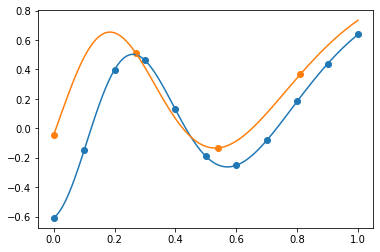

In [ ]:
def hf (x) :
  return 0.5*np.sin(4*np.pi*np.sin(x.flatten()+0.5)) + (x.flatten()+0.5)**(2) / 3
def lf (x) :
  return 0.5*np.sin(4*np.pi*np.sin(1.1*x.flatten()+0.4)) + (1.1*x.flatten()+0.5)**(2) / 3 - 0.2

x=[]
asdf = np.linspace(0,1,11)
d = [[temp] for temp in asdf]

x.append(np.array(d))
x.append(np.array([[0],[0.27],[0.54],[0.81]]))

y=[]
y.append(lf(x[0]))
y.append(hf(x[1]))

print(x[0].shape)
print(y[0].shape)
x_test = np.linspace(0,1,101)
plt.plot(x_test,lf(x_test))
plt.plot(x_test,hf(x_test))

plt.scatter(x[0],y[0])
plt.scatter(x[1],y[1])

In [ ]:

HK_meta = read_dat("./MyDrive/MyDrive/Colab Notebooks/data fusion/HK_technical_comment/HK_meta.dat")
HK_scaling = read_dat("./MyDrive/MyDrive/Colab Notebooks/data fusion/HK_technical_comment/HK_scaling.dat")
Proposed_meta = read_dat("./MyDrive/MyDrive/Colab Notebooks/data fusion/HK_technical_comment/Proposed_meta.dat")
Proposed_scaling = read_dat("./MyDrive/MyDrive/Colab Notebooks/data fusion/HK_technical_comment/Proposed_scaling.dat")

print(HK_meta.shape)
print(HK_scaling.shape)
print(Proposed_meta.shape)
print(Proposed_scaling.shape)

(34, 2)
(45, 2)
(59, 2)
(32, 2)


In [ ]:
q = {}
q["npop"]= 100
q["nge"]= 200
HK_i = HK(x,y,q,"i")
_,_ = HK_i.regression()

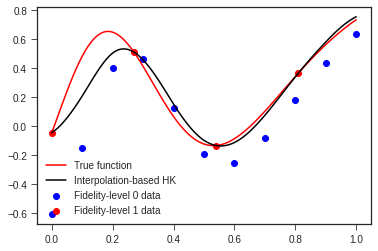

0.7179836742747994


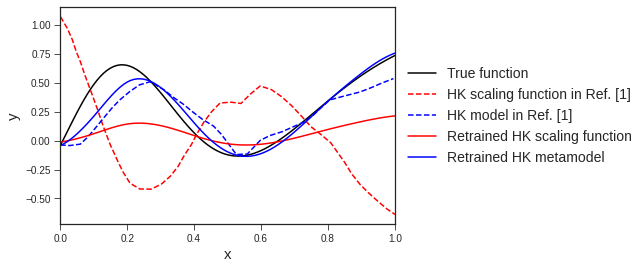

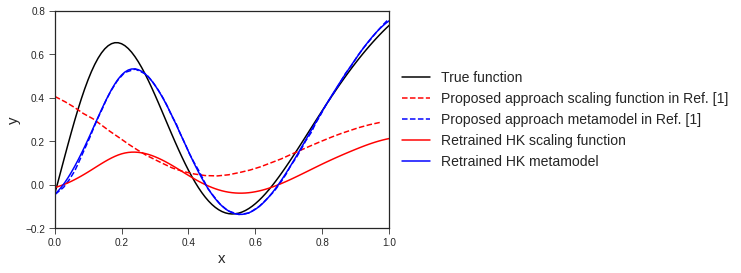

0.277770585361231
0.10330363761729065
0.7179836742747997


In [ ]:
HK_i.plot_var(x_test,1,hf)

y_pred_hf= HK_i.prediction(x_test, 1)
y_pred_lf= HK_i.prediction(x_test, 1)
print(HK_i.total_beta[1])
scale = y_pred_hf[0] - y_pred_lf[0] * HK_i.total_beta[1]
# plt.scatter(x_test,y_HK_n,c='k',label="Training points")
plt.plot(x_test,hf(x_test),'k-',label="True function")


plt.plot(HK_scaling[:,0],HK_scaling[:,1],'r--',label = "HK scaling function in Ref. [1]")
plt.plot(HK_meta[:,0],HK_meta[:,1],'b--',label = "HK model in Ref. [1]")

plt.plot(x_test,scale,'r-',label = "Retrained HK scaling function")
plt.plot(x_test,y_pred_hf[0],'b-',label = "Retrained HK metamodel")
plt.legend(fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0,1)
# plt.ylim(-0.2,0.8)
plt.xlabel("x",fontsize=15)
plt.ylabel("y",fontsize=15)
plt.savefig('./MyDrive/MyDrive/Colab Notebooks/data fusion/HK_technical_comment/fig1a.png', dpi=300, bbox_inches='tight')
plt.show()

plt.plot(x_test,hf(x_test),'k-',label="True function")

plt.plot(Proposed_scaling[:,0],Proposed_scaling[:,1],'r--', label = "Proposed approach scaling function in Ref. [1]")
plt.plot(Proposed_meta[:,0],Proposed_meta[:,1],'b--', label = "Proposed approach metamodel in Ref. [1]")

plt.plot(x_test,scale,'r-',label = "Retrained HK scaling function")
plt.plot(x_test,y_pred_hf[0],'b-',label = "Retrained HK metamodel")




plt.legend(fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0,1)
plt.ylim(-0.2,0.8)
plt.xlabel("x",fontsize=15)
plt.ylabel("y",fontsize=15)
plt.savefig('./MyDrive/MyDrive/Colab Notebooks/data fusion/HK_technical_comment/fig1b.png', dpi=300, bbox_inches='tight')
plt.show()

RMSE_, MAE_, beta_ = [],[],[]
for randomn in range(100):
  x_val = np.random.uniform(0,1,200)
  y_val= HK_i.prediction(x_val, 1)

  RMSE = np.sqrt(np.sum((hf(x_val) - y_val[0])**2) / 200)
  MAE = np.max(np.abs(hf(x_val) - y_val[0]))
  RMSE_.append(RMSE)
  MAE_.append(MAE)
  beta_.append(HK_i.total_beta[1])
print(np.array(MAE_).mean())
print(np.array(RMSE_).mean())
print(np.array(beta_).mean())

**B. Multidimensional Numerical Examples**

In [ ]:
# Rosenbrock function
def R_hf (x) :
  return 100*(x[:,0]**2 - x[:,1])**2 + (x[:,0] - 1)**2
def R_lf (x) :
  return 70*(x[:,0]**2 - x[:,1])**2 + 0.7 * (x[:,0] - 1)**2

# SC function
def sc (x) :
  return 4*x[:,0]**2 - 2.1 * x[:,0] ** 4 + x[:,0] ** 6 / 3 + x[:,0] * x[:,1] - 4 * x[:,1] ** 2 + 4 * x[:,1] ** 4
def S_hf (x) :
  return sc(x)
def S_lf (x) :
  return sc(0.7*x) + x[:,0] * x[:,1] - 65

# Hartmann 6 function
class Hartmann:
  def __init__(self):
    self.alpha = np.array([1.0, 2.0, 3.0, 4.0])
    self.alpha_prime = np.array([0.5, 0.5, 2.0, 4.0])
    self.A = np.array([[10, 3, 17, 3.5, 1.7, 8],
                  [0.05, 10, 17, 0.1, 8, 14],
                  [3, 3.5, 1.7, 10, 17, 8],
                  [17, 8, 0.05, 10, 0.1, 14]])
    self.P = 1e-4 * np.array([[1312, 1696, 5569, 124, 8283, 5886],
                          [2329, 4135, 8307, 3736, 1004, 9991],
                          [2348, 1451, 3522, 2883, 3047, 6650],
                          [4047, 8828, 8732, 5743, 1091, 381]])
    
  def H_hf (self, x) :
    ans = 0
    for i in range(4):
      inner = 0
      for j in range(6):
        inner += - (self.A[i,j] * (x[:,j] - self.P[i,j]) ** 2)
      ans += self.alpha[i] * np.exp(inner)
    return -1/1.94 * (2.58 + ans)
  
  def H_lf (self, x) :
    def f_exp (x) :
      return (np.exp(-4/9) + np.exp(-4/9) * (x + 4) / 9) ** 2

    ans = 0
    for i in range(4):
      inner = 0
      for j in range(6):
        inner += - (self.A[i,j] * (x[:,j] - self.P[i,j]) ** 2)
      ans += self.alpha_prime[i] * f_exp(inner)
    return -1/1.94 * (2.58 + ans)

# Borehole function
def f_borehole (x) :
  return 2 * np.pi * x[:,2] * (x[:,3] - x[:,5]) / np.log(x[:,1] / x[:,0]) / (1 + 2 * x[:,6] * x[:,3] / np.log(x[:,1]/x[:,0]) * x[:,0]**2 * x[:,7] + x[:,2] / x[:,4])
def B_hf (x) :
  return f_borehole(x)
def B_lf (x) :
  return 0.4 * f_borehole(x) + 0.07 * x[:,0] ** 2 * x[:,7] + x[:,0] * x[:,6] / x[:,2] + x[:,0] * x[:,5] / x[:,1] + x[:,0] ** 2 * x[:,3]

In [ ]:
def random_train (case_num = 1, func = "R"):
  if case_num == 1:
    sample_size = [30,15]
  elif case_num == 2:
    sample_size = [45,15]
  elif case_num == 3:
    sample_size = [60,30]
  elif case_num == 4:
    sample_size = [90,30]

  if func == "R":
    hf_x = pyDOE.lhs(2,sample_size[1],"m")
    lf_x = pyDOE.lhs(2,sample_size[0],"m")
    hf_x = hf_x * 4.096 - 2.048
    lf_x = lf_x * 4.096 - 2.048
    hf_y = R_hf(hf_x)
    lf_y = R_lf(lf_x)
  elif func == "S":
    hf_x = pyDOE.lhs(2,sample_size[1],"m")
    lf_x = pyDOE.lhs(2,sample_size[0],"m")
    hf_x = hf_x * 4 - 2.
    lf_x = lf_x * 4 - 2.
    hf_y = S_hf(hf_x)
    lf_y = S_lf(lf_x)
  elif func == "H":
    hf_x = pyDOE.lhs(6,sample_size[1],"m")
    lf_x = pyDOE.lhs(6,sample_size[0],"m")
    hf_x = hf_x * .9 + .1
    lf_x = lf_x * .9 + .1
    hf_y = Hartmann().H_hf(hf_x)
    lf_y = Hartmann().H_lf(lf_x)

  elif func == "B":
    hf_x = pyDOE.lhs(8,sample_size[1],"m")
    lf_x = pyDOE.lhs(8,sample_size[0],"m")
    x_bound = np.array([[0.05, 0.15],
                        [100, 50000],
                        [63070, 115600],
                        [990, 1110],
                        [63.1, 116],
                        [700, 820],
                        [1120, 1680],
                        [9855, 12045],
                        ])
    for idx, ele in enumerate(x_bound):
      hf_x[:,idx] = hf_x[:,idx] * (ele[1] - ele[0]) + ele[0]
      lf_x[:,idx] = lf_x[:,idx] * (ele[1] - ele[0]) + ele[0]
    hf_y = B_hf(hf_x)
    lf_y = B_lf(lf_x)

  return [lf_x, hf_x], [np.reshape(lf_y,(-1)), np.reshape(hf_y,(-1))]

def make_test_pts (test_pts = 200, func = "R"):
  if func == "R":
    test_ = pyDOE.lhs(2,test_pts,"m") * 4.096 - 2.048
  elif func == "S":
    test_ = pyDOE.lhs(2,test_pts,"m") * 4. - 2.
  elif func == "H":
    test_ = pyDOE.lhs(6,test_pts,"m") * .9 + .1
  elif func == "B":
    x_bound = np.array([[0.05, 0.15],
                            [100, 50000],
                            [63070, 115600],
                            [990, 1110],
                            [63.1, 116],
                            [700, 820],
                            [1120, 1680],
                            [9855, 12045],
                            ])
    test_ = pyDOE.lhs(8,test_pts,"m")
    for idx, ele in enumerate(x_bound):
          test_[:,idx] = test_[:,idx] * (ele[1] - ele[0]) + ele[0]
  
  return test_

In [ ]:
print("Rosenbrock function")
func = "R"
q = {}
q["npop"]= 30
q["nge"]= 200
MAE_case, RMSE_case = [], []
n_iter = 15
val_n_iter = 30
for case_ in [1,2,3,4]:
  print("Case", case_, "starts")
  MAE_, RMSE_ = [], []
  for i in range(n_iter):
    MAE__, RMSE__ = [], []
    x, y = random_train(case_num = case_, func= func)
    HK_i = HK(x,y,q,"i")  
    _,_ = HK_i.regression()
    for j in range(val_n_iter):
      test_pts = make_test_pts(test_pts = 200, func = func)
      y_real = R_hf(test_pts)
      y_pred = HK_i.prediction(test_pts, 1)[0]
      
      RMSE = np.sqrt(np.sum((y_pred - y_real)**2) / 200)
      MAE = np.max(np.abs(y_pred - y_real))
      MAE__.append(MAE)
      RMSE__.append(RMSE)

    #num = 100
    #plt.plot(np.arange(1,num+1,1),y_pred[:num])
    #plt.plot(np.arange(1,num+1,1),y_real[:num])
    #plt.show()
    MAE_.append(np.array(MAE__).mean())
    RMSE_.append(np.array(RMSE__).mean())
  MAE_case.append(np.array(MAE_).mean())
  RMSE_case.append(np.array(RMSE_).mean())

for case_ in [1,2,3,4]:
  print(f"Case{case_} MAE: ", MAE_case[case_-1])
  print(f"Case{case_} RMSE: ", RMSE_case[case_-1])

Rosenbrock function
Case 1 starts
Case 2 starts
Case 3 starts
Case 4 starts
Case1 MAE:  439.2971377553216
Case1 RMSE:  67.8672762103269
Case2 MAE:  178.7215704383315
Case2 RMSE:  30.73386138904643
Case3 MAE:  87.56396976818732
Case3 RMSE:  13.640932152237315
Case4 MAE:  61.26124274018139
Case4 RMSE:  8.119198903146158


In [ ]:
print("SC function")
func = "S"
q = {}
q["npop"]= 30
q["nge"]= 200
MAE_case, RMSE_case = [], []
n_iter = 15
val_n_iter = 30
for case_ in [1,2,3,4]:
  print("Case", case_, "starts")
  MAE_, RMSE_ = [], []
  for i in range(n_iter):
    MAE__, RMSE__ = [], []
    x, y = random_train(case_num = case_, func= func)
    HK_i = HK(x,y,q,"i")  
    _,_ = HK_i.regression()
    for j in range(val_n_iter):
      test_pts = make_test_pts(test_pts = 200, func = func)
      y_real = S_hf(test_pts)
      y_pred = HK_i.prediction(test_pts, 1)[0]
      
      RMSE = np.sqrt(np.sum((y_pred - y_real)**2) / 200)
      MAE = np.max(np.abs(y_pred - y_real))
      MAE__.append(MAE)
      RMSE__.append(RMSE)

    MAE_.append(np.array(MAE__).mean())
    RMSE_.append(np.array(RMSE__).mean())
  MAE_case.append(np.array(MAE_).mean())
  RMSE_case.append(np.array(RMSE_).mean())

for case_ in [1,2,3,4]:
  print(f"Case{case_} MAE: ", MAE_case[case_-1])
  print(f"Case{case_} RMSE: ", RMSE_case[case_-1])

SC function
Case 1 starts
Case 2 starts
Case 3 starts
Case 4 starts
Case1 MAE:  5.701120433267287
Case1 RMSE:  1.1338452327722577
Case2 MAE:  5.424633682838322
Case2 RMSE:  1.0524845000890564
Case3 MAE:  2.5447416008285115
Case3 RMSE:  0.5865026392857337
Case4 MAE:  2.3772090995497392
Case4 RMSE:  0.5312859651850338


In [ ]:
print("Hartmann 6 function")
func = "H"
q = {}
q["npop"]= 50
q["nge"]= 600
MAE_case, RMSE_case = [], []
n_iter = 15
val_n_iter = 30
for case_ in [1,2,3,4]:
  print("Case", case_, "starts")
  MAE_, RMSE_ = [], []
  for i in range(n_iter):
    MAE__, RMSE__ = [], []
    x, y = random_train(case_num = case_, func= func)
    HK_i = HK(x,y,q,"i")  
    _,_ = HK_i.regression()
    for j in range(val_n_iter):
      test_pts = make_test_pts(test_pts = 200, func = func)
      y_real = Hartmann().H_hf(test_pts)
      y_pred = HK_i.prediction(test_pts, 1)[0]
      
      RMSE = np.sqrt(np.sum((y_pred - y_real)**2) / 200)
      MAE = np.max(np.abs(y_pred - y_real))
      MAE__.append(MAE)
      RMSE__.append(RMSE)

    MAE_.append(np.array(MAE__).mean())
    RMSE_.append(np.array(RMSE__).mean())
  MAE_case.append(np.array(MAE_).mean())
  RMSE_case.append(np.array(RMSE_).mean())

for case_ in [1,2,3,4]:
  print(f"Case{case_} MAE: ", MAE_case[case_-1])
  print(f"Case{case_} RMSE: ", RMSE_case[case_-1])

Hartmann 6 function
Case 1 starts
Case 2 starts
Case 3 starts
Case 4 starts
Case1 MAE:  1.0153513978264874
Case1 RMSE:  0.2567228719589651
Case2 MAE:  0.9844013520689582
Case2 RMSE:  0.23560307398038102
Case3 MAE:  0.8884851071782705
Case3 RMSE:  0.22750838742122031
Case4 MAE:  0.8888357641512504
Case4 RMSE:  0.208128015483758


In [ ]:
print("Borehole function")
func = "B"
q = {}
q["npop"]= 50
q["nge"]= 800
MAE_case, RMSE_case = [], []
n_iter = 15
val_n_iter = 30
for case_ in [1,2,3,4]:
  print("Case", case_, "starts")
  MAE_, RMSE_ = [], []
  for i in range(n_iter):
    MAE__, RMSE__ = [], []
    x, y = random_train(case_num = case_, func= func)
    HK_i = HK(x,y,q,"i")  
    _,_ = HK_i.regression()
    for j in range(val_n_iter):
      test_pts = make_test_pts(test_pts = 200, func = func)
      y_real = B_hf(test_pts)
      y_pred = HK_i.prediction(test_pts, 1)[0]
      
      RMSE = np.sqrt(np.sum((y_pred - y_real)**2) / 200)
      MAE = np.max(np.abs(y_pred - y_real))
      MAE__.append(MAE)
      RMSE__.append(RMSE)

    MAE_.append(np.array(MAE__).mean())
    RMSE_.append(np.array(RMSE__).mean())
  MAE_case.append(np.array(MAE_).mean())
  RMSE_case.append(np.array(RMSE_).mean())
  print(f"Case{case_} MAE: ", MAE_case[case_-1])
  print(f"Case{case_} RMSE: ", RMSE_case[case_-1])


Borehole function
Case 1 starts
Case1 MAE:  1.9995403739711581
Case1 RMSE:  0.5078999417116494
Case 2 starts
Case2 MAE:  1.9151775370146922
Case2 RMSE:  0.4753096842788341
Case 3 starts
Case3 MAE:  1.4582108850095703
Case3 RMSE:  0.3646384418366911
Case 4 starts
Case4 MAE:  1.4021499221245761
Case4 RMSE:  0.3376952289479025


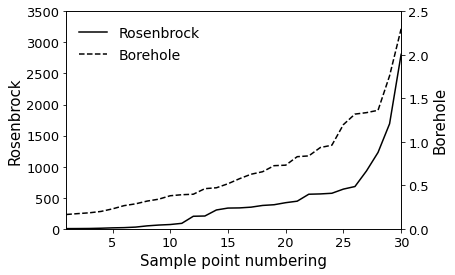

In [ ]:
lhs_test = 30
test_pts_R = make_test_pts(test_pts = lhs_test, func = "R")
y_real_R = R_hf(test_pts_R)

test_pts_B = make_test_pts(test_pts = lhs_test, func = "B")
y_real_B = B_hf(test_pts_B)

fig, ax1 = plt.subplots()
ax1.plot(np.arange(1,lhs_test+1,1), np.sort(y_real_R), 'k-', label = 'Rosenbrock')
# ax1.scatter(np.arange(1,lhs_test+1,1), np.sort(y_real_R), color='k', marker='o')
ax2 = ax1.twinx()
ax2.plot(np.arange(1,lhs_test+1,1), np.sort(y_real_B), 'k--', label = 'Borehole')
# ax2.scatter(np.arange(1,lhs_test+1,1), np.sort(y_real_B), color='k', marker='x')

ax1.set_xlim(1,30)
ax1.set_ylim(0,3000)
ax1.set_yticks([500*i for i in range(8)])
ax1.tick_params(labelsize=13)
ax2.set_ylim(0,2.0)
ax2.set_yticks([.5*i for i in range(6)])
ax2.tick_params(labelsize=13)


ax1.legend(fontsize=14,loc='center left', bbox_to_anchor=(0, 0.9),frameon=False)
ax2.legend(fontsize=14,loc='center left', bbox_to_anchor=(0, 0.8),frameon=False)

ax1.set_xlabel("Sample point numbering",fontsize=15)
ax1.set_ylabel("Rosenbrock",fontsize=15)
ax2.set_ylabel("Borehole",fontsize=15)
plt.savefig('./MyDrive/MyDrive/Colab Notebooks/data fusion/HK_technical_comment/RB_LHS.png', dpi=300, bbox_inches='tight')
plt.show()


**C. Engineering case**

In [ ]:
LF_eng = read_dat("./MyDrive/MyDrive/Colab Notebooks/data fusion/HK_technical_comment/LF_eng.dat")
HFtrain_eng = read_dat("./MyDrive/MyDrive/Colab Notebooks/data fusion/HK_technical_comment/HFtrain_eng.dat")
HFtest_eng = read_dat("./MyDrive/MyDrive/Colab Notebooks/data fusion/HK_technical_comment/HFtest_eng.dat")

print(LF_eng.shape)
print(HFtrain_eng.shape)
print(HFtest_eng.shape)

(45, 7)
(15, 7)
(20, 7)


In [ ]:
LF_x = np.zeros(LF_eng.shape)
LF_x = np.delete(LF_x,-1,1)
LF_y = np.zeros((LF_x.shape[0]))
HFtrain_x = np.zeros(HFtrain_eng.shape)
HFtrain_x = np.delete(HFtrain_x,-1,1)
HFtrain_y = np.zeros((HFtrain_x.shape[0]))
HFtest_x = np.zeros(HFtest_eng.shape)
HFtest_x = np.delete(HFtest_x,-1,1)
HFtest_y = np.zeros((HFtest_x.shape[0]))

for enu,i in enumerate(LF_eng):
  LF_x[enu,:] = i[:-1]
  LF_y[enu] = i[-1]
for enu,i in enumerate(HFtrain_eng):
  HFtrain_x[enu,:] = i[:-1]
  HFtrain_y[enu] = i[-1]
for enu,i in enumerate(HFtest_eng):
  HFtest_x[enu,:] = i[:-1]
  HFtest_y[enu] = i[-1]

LF_x = ( LF_x - LF_x.mean(axis=0) ) / LF_x.std(axis=0)
HFtrain_x = ( HFtrain_x - HFtrain_x.mean(axis=0) ) / HFtrain_x.std(axis=0)
HFtest_x = ( HFtest_x - HFtest_x.mean(axis=0) ) / HFtest_x.std(axis=0)
# LF_x = ( LF_x - LF_x.min(axis=0) ) / ( LF_x.max(axis=0) -  LF_x.min(axis=0))
# HFtrain_x = ( HFtrain_x - HFtrain_x.min(axis=0) ) / ( HFtrain_x.max(axis=0) -  HFtrain_x.min(axis=0))
# HFtest_x = ( HFtest_x - HFtest_x.min(axis=0) ) / ( HFtest_x.max(axis=0) -  HFtest_x.min(axis=0))


x=[]
x.append(LF_x)
x.append(HFtrain_x)
y=[]
y.append(LF_y)
y.append(HFtrain_y)

q = {}
q["npop"]= 300
q["nge"]= 300
HK_eng = HK(x,y,q,"i")
_,_ = HK_eng.regression()



In [ ]:
for i in HK_eng.total_opt_theta[0]:
  print(f"{i:.2E}")
print()
for i in HK_eng.total_opt_theta[1]:
  print(f"{i:.2E}")

3.04E-04
2.45E-04
6.89E-04
6.11E-03
7.01E-03
6.40E-02

1.26E-04
4.04E-06
7.64E-02
1.57E-01
1.53E-01
1.16E-01


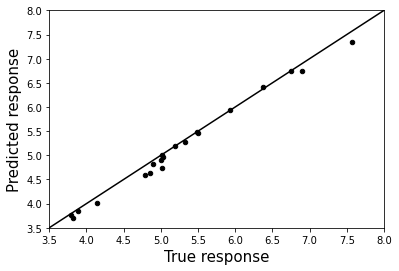

<Figure size 864x720 with 0 Axes>

0.9921620783142487
0.2896976958592976 0.12154407618286925


In [ ]:
y_pred_hf_eng= HK_eng.prediction(HFtest_x, 1)[0]
plt.scatter(HFtest_y,y_pred_hf_eng,color='k',s=20,label="HK model")
plt.plot([0,100],[0,100],'k')
plt.xlabel("True response",fontsize=15)
plt.ylabel("Predicted response",fontsize=15)
plt.xlim(3.5,8)
plt.ylim(3.5,8)
# plt.figure(figsize=(4,4))
# plt.gca().set_aspect('equal', adjustable='box')
# plt.gca().set_aspect('equal')
plt.savefig('./MyDrive/MyDrive/Colab Notebooks/data fusion/HK_technical_comment/fig_eng_cv.png', dpi=300, bbox_inches='tight')
plt.figure(figsize=(12, 10))
plt.show()

correlation_matrix = np.corrcoef(HFtest_y, y_pred_hf_eng)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print(r_squared)

RMSE = np.sqrt(np.sum((HFtest_y - y_pred_hf_eng)**2) / 20)
MAE = np.max(np.abs(HFtest_y - y_pred_hf_eng))
print(MAE,RMSE)

In [ ]:
# pop = [50, 50]
# gen = [200,200]
# HK_i = HK(x,y,pop,gen,"i")
# HK_i.train_HK("y")


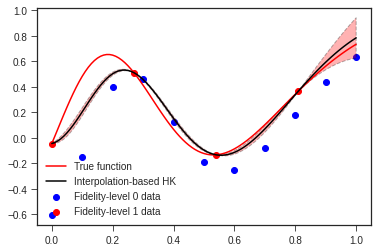

0.7251184000991107


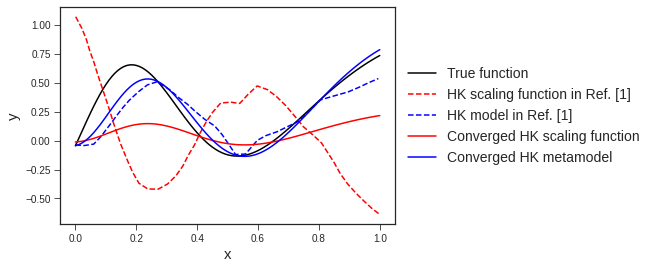

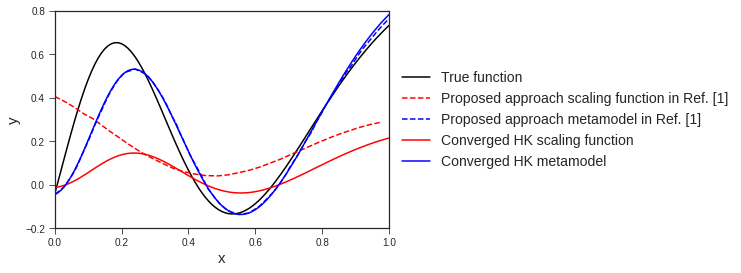

0.2794833632216966
0.10846306993282089
0.7251184000991104


In [ ]:
# HK_i.plot_var(x_test,1,hf)

# y_pred_hf= HK_i.pred_y_MSE(x_test, 1)
# y_pred_lf= HK_i.pred_y_MSE(x_test, 1)
# print(HK_i.total_beta[1])
# scale = y_pred_hf[0] - y_pred_lf[0] * HK_i.total_beta[1]
# # plt.scatter(x_test,y_HK_n,c='k',label="Training points")
# plt.plot(x_test,hf(x_test),'k-',label="True function")


# plt.plot(HK_scaling[:,0],HK_scaling[:,1],'r--',label = "HK scaling function in Ref. [1]")
# plt.plot(HK_meta[:,0],HK_meta[:,1],'b--',label = "HK model in Ref. [1]")

# plt.plot(x_test,scale,'r-',label = "Converged HK scaling function")
# plt.plot(x_test,y_pred_hf[0],'b-',label = "Converged HK metamodel")
# plt.legend(fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
# # plt.xlim(0,1)
# # plt.ylim(-0.2,0.8)
# plt.xlabel("x",fontsize=15)
# plt.ylabel("y",fontsize=15)
# plt.show()

# plt.plot(x_test,hf(x_test),'k-',label="True function")

# plt.plot(Proposed_scaling[:,0],Proposed_scaling[:,1],'r--', label = "Proposed approach scaling function in Ref. [1]")
# plt.plot(Proposed_meta[:,0],Proposed_meta[:,1],'b--', label = "Proposed approach metamodel in Ref. [1]")

# plt.plot(x_test,scale,'r-',label = "Converged HK scaling function")
# plt.plot(x_test,y_pred_hf[0],'b-',label = "Converged HK metamodel")




# plt.legend(fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(0,1)
# plt.ylim(-0.2,0.8)
# plt.xlabel("x",fontsize=15)
# plt.ylabel("y",fontsize=15)
# plt.show()

# RMSE_, MAE_, beta_ = [],[],[]
# for randomn in range(100):
#   x_val = np.random.uniform(0,1,200)
#   y_val= HK_i.pred_y_MSE(x_val, 1)
#   # print(hf(x_val))

#   RMSE = np.sqrt(np.sum((hf(x_val) - y_val[0])**2) / 200)
#   MAE = np.max(np.abs(hf(x_val) - y_val[0]))
#   RMSE_.append(RMSE)
#   MAE_.append(MAE)
#   beta_.append(HK_i.total_beta[1])
#   # print(RMSE,MAE)
#   # print(HK_i.total_beta)
# # plt.plot(x_val,y_val)
# print(np.array(MAE_).mean())
# print(np.array(RMSE_).mean())
# print(np.array(beta_).mean())

In [ ]:
# LF_x = np.zeros(LF_eng.shape)
# LF_x = np.delete(LF_x,-1,1)
# LF_y = np.zeros((LF_x.shape[0]))
# HFtrain_x = np.zeros(HFtrain_eng.shape)
# HFtrain_x = np.delete(HFtrain_x,-1,1)
# HFtrain_y = np.zeros((HFtrain_x.shape[0]))
# HFtest_x = np.zeros(HFtest_eng.shape)
# HFtest_x = np.delete(HFtest_x,-1,1)
# HFtest_y = np.zeros((HFtest_x.shape[0]))

# for enu,i in enumerate(LF_eng):
#   LF_x[enu,:] = i[:-1]
#   LF_y[enu] = i[-1]
# for enu,i in enumerate(HFtrain_eng):
#   HFtrain_x[enu,:] = i[:-1]
#   HFtrain_y[enu] = i[-1]
# for enu,i in enumerate(HFtest_eng):
#   HFtest_x[enu,:] = i[:-1]
#   HFtest_y[enu] = i[-1]

# LF_x = ( LF_x - LF_x.mean(axis=0) ) / LF_x.std(axis=0)
# HFtrain_x = ( HFtrain_x - HFtrain_x.mean(axis=0) ) / HFtrain_x.std(axis=0)
# HFtest_x = ( HFtest_x - HFtest_x.mean(axis=0) ) / HFtest_x.std(axis=0)
# # LF_x = ( LF_x - LF_x.min(axis=0) ) / ( LF_x.max(axis=0) -  LF_x.min(axis=0))
# # HFtrain_x = ( HFtrain_x - HFtrain_x.min(axis=0) ) / ( HFtrain_x.max(axis=0) -  HFtrain_x.min(axis=0))
# # HFtest_x = ( HFtest_x - HFtest_x.min(axis=0) ) / ( HFtest_x.max(axis=0) -  HFtest_x.min(axis=0))


# x=[]
# x.append(LF_x)
# x.append(HFtrain_x)
# y=[]
# y.append(LF_y)
# y.append(HFtrain_y)

# pop = [300,300]
# gen = [200,200]
# HK_eng = HK(x,y,pop,gen,"i")
# HK_eng.train_HK("y")



#########  Level 0 starts  #########
   Generation = 98
   Optimal theta = [1.34759700e-05 1.34608242e-04 3.78634170e-03 7.53355039e-03
 1.24878197e-02 1.09696125e-01]
   Optimal likelihood = 119.040394
   Optimal R's condition number = 21787803.469776
   Level 0 finishes with time 626.819868[s]
#########  Level 1 starts  #########
   Generation = 87
   Optimal theta = [1.47681463e-01 1.01952254e-06 4.19002742e-01 1.04292527e-06
 1.07949217e-06 6.39618726e-01]
   Optimal likelihood = 53.934851
   Optimal R's condition number = 99.595891
   Level 1 finishes with time 68.726897[s]
#########  Total time = 695.548453[s]  #########



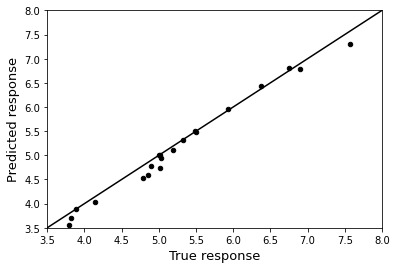

<Figure size 864x720 with 0 Axes>

0.9885284537007936
0.14219204947759298 0.2828410716945573


In [ ]:
# y_pred_hf_eng= HK_eng.pred_y_MSE(HFtest_x, 1)[0]
# plt.scatter(HFtest_y,y_pred_hf_eng,color='k',s=20,label="HK model")
# plt.plot([0,100],[0,100],'k')
# plt.xlabel("True response",fontsize=13)
# plt.ylabel("Predicted response",fontsize=13)
# plt.xlim(3.5,8)
# plt.ylim(3.5,8)
# # plt.figure(figsize=(4,4))
# # plt.gca().set_aspect('equal', adjustable='box')
# # plt.gca().set_aspect('equal')
# plt.figure(figsize=(12, 10))

# # plt.figure(figsize=(4,4))
# # plt.label(font)
# plt.show()

# correlation_matrix = np.corrcoef(HFtest_y, y_pred_hf_eng)
# correlation_xy = correlation_matrix[0,1]
# r_squared = correlation_xy**2
# print(r_squared)

# RMSE = np.sqrt(np.sum((HFtest_y - y_pred_hf_eng)**2) / 20)
# MAE = np.max(np.abs(HFtest_y - y_pred_hf_eng))
# print(RMSE,MAE)